In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_origin =  '/content/drive/MyDrive/personal projects/cats & dogs/DATA/CATS_DOGS'

In [4]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [5]:
train_path = data_origin+'/train'
data_transforms = transforms.Compose([
                    transforms.Resize((128,128)),
                    transforms.ToTensor()])
image_datasets = ImageFolder(root= train_path, transform=data_transforms)

Label: 1
torch.Size([3, 128, 128])


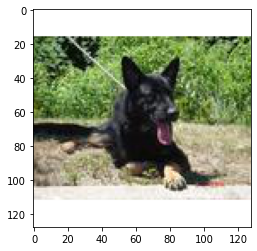

In [6]:
image,label = image_datasets[18000]
print('Label: '+str(label))
print(image.shape)
plt.imshow(image.permute(1,2,0))

In [7]:
dataloaders = DataLoader(image_datasets, batch_size=64, shuffle=True
                                          , num_workers=3)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
from torchvision.utils import make_grid
def show_batch(data_loader):
  for img,lb in dataloaders:
    fig,axis = plt.subplots(figsize=(12,6))
    axis.set_xticks([]);axis.set_yticks([])
    axis.imshow(make_grid(img,nrow=16).permute(1,2,0))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


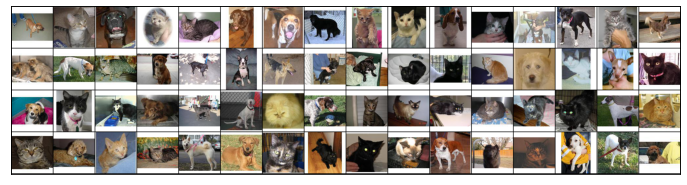

In [9]:
show_batch(data_loader=dataloaders)

In [10]:
print(image_datasets.classes)

['CAT', 'DOG']


In [11]:
len(image_datasets)

18743

In [12]:
from torch.utils.data.dataset import random_split
lengths = [10743, 8000]
train_data, val_data = random_split(image_datasets,lengths)

In [13]:
print('Train Length = ' + str(len(train_data)))
print('Validation Length = ' + str(len(val_data)))

Train Length = 10743
Validation Length = 8000


In [14]:
train_loaders = DataLoader(train_data, batch_size=128, shuffle=True
                                          , num_workers=3)
val_loaders = DataLoader(val_data, batch_size=128, shuffle=True
                                          , num_workers=3)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [15]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassifier(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))


class ConvNetwork(ImageClassifier):
  def __init__(self, in_channels, num_classes):
    super(ConvNetwork, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32
                           ,kernel_size=3, padding= 2,)
    self.batchn1 = nn.BatchNorm2d(32)
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)

    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,
			kernel_size=5,padding=2,stride=2)
    self.batchn2 = nn.BatchNorm2d(64)
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2,padding=1)
		# initialize first (and only) set of FC => RELU layers
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(in_features=64, out_features=num_classes)
   
  def forward(self,input):
    input = self.conv1(input)
    input = self.batchn1(input)
    input = self.relu1(input)
    input = self.maxpool1(input)
    input = self.conv2(input)
    input = self.batchn2(input)
    input = self.relu2(input)
    input = self.maxpool2(input)
    input = self.avgpool(input)
    input = input.reshape(input.shape[0], -1)
    input = self.fc(input)

    return input

In [16]:
model = ConvNetwork(in_channels=3, num_classes=2)
model

ConvNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (batchn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (batchn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
torch.cuda.empty_cache()

In [20]:
model = to_device(model, device)
model

ConvNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (batchn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (batchn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [21]:
@torch.no_grad()
def evaluate(model, val_loaders):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loaders]
    return model.validation_epoch_end(outputs)
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
train_loaders = DeviceDataLoader(train_loaders, device)
val_loaders = DeviceDataLoader(val_loaders, device)

In [ ]:
history = [evaluate(model, val_loaders=val_loaders)]
history